In [1]:
from typing import Callable, Iterator, Tuple
import chex
import jax

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import jaxopt

from math import pi, log
from ripple.typing import Array
from scipy.optimize import minimize, minimize_scalar

from numpy import random, abs
from ripple.waveforms import IMRPhenomD, IMRPhenomD_utils
from ripple.waveforms.IMRPhenomD import *
from ripple.waveforms.IMRPhenomD_utils import get_coeffs, get_transition_frequencies
from ripple import ms_to_Mc_eta, Mc_eta_to_ms
from jax import grad, vmap, scipy
from functools import partial
import time

PhenomD_coeff_table = jnp.array(
    [
        [  # rho1 (element 0)
            3931.8979897196696,
            -17395.758706812805,
            3132.375545898835,
            343965.86092361377,
            -1.2162565819981997e6,
            -70698.00600428853,
            1.383907177859705e6,
            -3.9662761890979446e6,
            -60017.52423652596,
            803515.1181825735,
            -2.091710365941658e6,
        ],
        [  # rho2 (element 1)
            -40105.47653771657,
            112253.0169706701,
            23561.696065836168,
            -3.476180699403351e6,
            1.137593670849482e7,
            754313.1127166454,
            -1.308476044625268e7,
            3.6444584853928134e7,
            596226.612472288,
            -7.4277901143564405e6,
            1.8928977514040343e7,
        ],
        [  # rho3 (element 2)
            83208.35471266537,
            -191237.7264145924,
            -210916.2454782992,
            8.71797508352568e6,
            -2.6914942420669552e7,
            -1.9889806527362722e6,
            3.0888029960154563e7,
            -8.390870279256162e7,
            -1.4535031953446497e6,
            1.7063528990822166e7,
            -4.2748659731120914e7,
        ],
        [  # v2 (element 3)
            0.8149838730507785,
            2.5747553517454658,
            1.1610198035496786,
            -2.3627771785551537,
            6.771038707057573,
            0.7570782938606834,
            -2.7256896890432474,
            7.1140380397149965,
            0.1766934149293479,
            -0.7978690983168183,
            2.1162391502005153,
        ],
        [  # gamma1 (element 4)
            0.006927402739328343,
            0.03020474290328911,
            0.006308024337706171,
            -0.12074130661131138,
            0.26271598905781324,
            0.0034151773647198794,
            -0.10779338611188374,
            0.27098966966891747,
            0.0007374185938559283,
            -0.02749621038376281,
            0.0733150789135702,
        ],
        [  # gamma2 (element 5)
            1.010344404799477,
            0.0008993122007234548,
            0.283949116804459,
            -4.049752962958005,
            13.207828172665366,
            0.10396278486805426,
            -7.025059158961947,
            24.784892370130475,
            0.03093202475605892,
            -2.6924023896851663,
            9.609374464684983,
        ],
        [  # gamma3 (element 6)
            1.3081615607036106,
            -0.005537729694807678,
            -0.06782917938621007,
            -0.6689834970767117,
            3.403147966134083,
            -0.05296577374411866,
            -0.9923793203111362,
            4.820681208409587,
            -0.006134139870393713,
            -0.38429253308696365,
            1.7561754421985984,
        ],
        [  # sig1 (element 7)
            2096.551999295543,
            1463.7493168261553,
            1312.5493286098522,
            18307.330017082117,
            -43534.1440746107,
            -833.2889543511114,
            32047.31997183187,
            -108609.45037520859,
            452.25136398112204,
            8353.439546391714,
            -44531.3250037322,
        ],
        [  # sig2 (element 8)
            -10114.056472621156,
            -44631.01109458185,
            -6541.308761668722,
            -266959.23419307504,
            686328.3229317984,
            3405.6372187679685,
            -437507.7208209015,
            1.6318171307344697e6,
            -7462.648563007646,
            -114585.25177153319,
            674402.4689098676,
        ],
        [  # sig3 (element 9)
            22933.658273436497,
            230960.00814979506,
            14961.083974183695,
            1.1940181342318142e6,
            -3.1042239693052764e6,
            -3038.166617199259,
            1.8720322849093592e6,
            -7.309145012085539e6,
            42738.22871475411,
            467502.018616601,
            -3.064853498512499e6,
        ],
        [  # sig4 (element 10)
            -14621.71522218357,
            -377812.8579387104,
            -9608.682631509726,
            -1.7108925257214056e6,
            4.332924601416521e6,
            -22366.683262266528,
            -2.5019716386377467e6,
            1.0274495902259542e7,
            -85360.30079034246,
            -570025.3441737515,
            4.396844346849777e6,
        ],
        [  # beta1 (element 11)
            97.89747327985583,
            -42.659730877489224,
            153.48421037904913,
            -1417.0620760768954,
            2752.8614143665027,
            138.7406469558649,
            -1433.6585075135881,
            2857.7418952430758,
            41.025109467376126,
            -423.680737974639,
            850.3594335657173,
        ],
        [  # beta2 (element 12)
            -3.282701958759534,
            -9.051384468245866,
            -12.415449742258042,
            55.4716447709787,
            -106.05109938966335,
            -11.953044553690658,
            76.80704618365418,
            -155.33172948098394,
            -3.4129261592393263,
            25.572377569952536,
            -54.408036707740465,
        ],
        [  # beta3 (element 13)
            -0.000025156429818799565,
            0.000019750256942201327,
            -0.000018370671469295915,
            0.000021886317041311973,
            0.00008250240316860033,
            7.157371250566708e-6,
            -0.000055780000112270685,
            0.00019142082884072178,
            5.447166261464217e-6,
            -0.00003220610095021982,
            0.00007974016714984341,
        ],
        [  # a1 (element 14)
            43.31514709695348,
            638.6332679188081,
            -32.85768747216059,
            2415.8938269370315,
            -5766.875169379177,
            -61.85459307173841,
            2953.967762459948,
            -8986.29057591497,
            -21.571435779762044,
            981.2158224673428,
            -3239.5664895930286,
        ],
        [  # a2 (element 15)
            -0.07020209449091723,
            -0.16269798450687084,
            -0.1872514685185499,
            1.138313650449945,
            -2.8334196304430046,
            -0.17137955686840617,
            1.7197549338119527,
            -4.539717148261272,
            -0.049983437357548705,
            0.6062072055948309,
            -1.682769616644546,
        ],
        [  # a3 (element 16)
            9.5988072383479,
            -397.05438595557433,
            16.202126189517813,
            -1574.8286986717037,
            3600.3410843831093,
            27.092429659075467,
            -1786.482357315139,
            5152.919378666511,
            11.175710130033895,
            -577.7999423177481,
            1808.730762932043,
        ],
        [  # a4 (element 17)
            -0.02989487384493607,
            1.4022106448583738,
            -0.07356049468633846,
            0.8337006542278661,
            0.2240008282397391,
            -0.055202870001177226,
            0.5667186343606578,
            0.7186931973380503,
            -0.015507437354325743,
            0.15750322779277187,
            0.21076815715176228,
        ],
        [  # a5 (element 18)
            0.9974408278363099,
            -0.007884449714907203,
            -0.059046901195591035,
            1.3958712396764088,
            -4.516631601676276,
            -0.05585343136869692,
            1.7516580039343603,
            -5.990208965347804,
            -0.017945336522161195,
            0.5965097794825992,
            -2.0608879367971804,
        ],
    ]
)


"""
Various constants, all in SI units.
"""

EulerGamma = 0.577215664901532860606512090082402431

MSUN = 1.9884099021470415e30  # kg
"""Solar mass"""

G = 6.67430e-11  # m^3 / kg / s^2
"""Newton's gravitational constant"""

C = 299792458.0  # m / s
"""Speed of light"""

gt = G * MSUN / (C ** 3.0)
"""
G MSUN / C^3 in seconds
"""

m_per_Mpc = 3.085677581491367278913937957796471611e22
"""
Meters per Mpc.
"""

#amp_scale = PhenomD_coeff_table[:7]
#phase_scale = PhenomD_coeff_table[7:]

'\nMeters per Mpc.\n'

In [2]:
@jax.jit
def _get_coeffs(theta: Array, table: Array) -> Array:
    # Retrives the coefficients needed to produce the waveform

    m1, m2, chi1, chi2 = theta
    m1_s = m1 * gt
    m2_s = m2 * gt
    M_s = m1_s + m2_s
    eta = m1_s * m2_s / (M_s ** 2.0)

    # Definition of chiPN from lalsuite
    chi_s = (chi1 + chi2) / 2.0
    chi_a = (chi1 - chi2) / 2.0
    seta = (1 - 4 * eta) ** (1 / 2)
    chiPN = chi_s * (1 - 76 * eta / 113) + seta * chi_a

    coeff = (
        table[:, 0]
        + table[:, 1] * eta
        + (chiPN - 1.0)
        * (
            table[:, 2]
            + table[:, 3] * eta
            + table[:, 4] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 2.0
        * (
            table[:, 5]
            + table[:, 6] * eta
            + table[:, 7] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 3.0
        * (
            table[:, 8]
            + table[:, 9] * eta
            + table[:, 10] * (eta ** 2.0)
        )
    )

    # FIXME: Change to dictionary lookup
    return coeff
#print(_get_coeffs(theta_intrinsic[0], PhenomD_coeff_table) - get_coeffs(theta_intrinsic[0]))

In [3]:
f_start = 16.0
f_end = 512.0
delta_f = 0.01
fs = jnp.arange(f_start, f_end, delta_f)

f_sep = 1600
f_list = jnp.array(fs[0::f_sep])

theta_intrinsic = jnp.array([
                   [25.0, 25.0, -0.95, -0.95], 
                   [25.0, 25.0, -0.60, -0.60], 
                   [25.0, 25.0, 0.00, 0.00], 
                   [25.0, 25.0, 0.60, 0.60], 
                   [25.0, 25.0, 0.98, 0.98], 
                   [40.0, 10.0, -0.75, -0.75],
                   [40.0, 10.0, -0.50, -0.50],
                   [40.0, 10.0, 0.00, 0.00],
                   [40.0, 10.0, 0.50, 0.50],
                   [40.0, 10.0, 0.75, 0.75],
                   [44.4, 5.6, -0.85, -0.85],
                   [44.4, 5.6, -0.50, 0.00],
                   [44.4, 5.6, 0.00, 0.00],
                   [44.4, 5.6, 0.50, 0.00],
                   [44.4, 5.6, 0.85, 0.85],
                   [44.4, 5.6, -0.85, -0.85],
                   [47.4, 2.6, -0.80, 0.00],
                   [47.4, 2.6, -0.40, 0.00],
                   [47.4, 2.6, 0.00, 0.00],
                   [47.4, 2.6, 0.40, 0.00]
                  ])
theta_extrinsic = jnp.array([440.0, 0.01, 0.0])

In [4]:
@jax.jit
def loss_amp(amp: Array, phase: Array, intrin: Array, extrin: Array, f: Array) -> Array:
    test_lambdas = jnp.resize(jnp.append(amp, phase), (19, 11))
    test_coeffs = _get_coeffs(intrin, test_lambdas)
    coeffs = get_coeffs(intrin)
    true = IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, coeffs)
    guess = IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, test_coeffs)
    return jnp.sum((jnp.abs(true) - jnp.abs(guess)) ** 2.) / jnp.sum(jnp.abs(true)**2.)

@jax.jit
def loss_phase_diff(phase: Array, amp: Array, intrin: Array, extrin: Array, f: Array) -> Array:
    test_lambdas = jnp.resize(jnp.append(amp, phase), (19, 11))
    test_coeffs = _get_coeffs(intrin, test_lambdas)
    coeffs = get_coeffs(intrin)
    true = jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, intrin, extrin, coeffs)))
    guess = jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, intrin, extrin, test_coeffs)))
    
    true_diff = (true[2:] - true[:-2]) / (2 * f_sep)
    guess_diff = (guess[2:] - guess[:-2]) / (2 * f_sep)
    return jnp.sum((true_diff[0::f_sep] - guess_diff[0::f_sep]) ** 2.) / jnp.sum(true_diff[0::f_sep] ** 2.)

@jax.jit
def total_loss_amp(amp: Array, phase: Array, all_intrin: Array, extrin: Array, f: Array) -> Array:
    return jnp.sum(jnp.array([loss_amp(amp, phase, i, extrin, f) for i in all_intrin]))

@jax.jit
def total_loss_phase_diff(phase: Array, amp: Array, all_intrin: Array, extrin: Array, f: Array) -> Array:
    return jnp.sum(jnp.array([loss_phase_diff(phase, amp, i, extrin, f) for i in all_intrin]))

"grad_amp = jax.grad(loss_amp)\nprint(grad_amp(test_amp / amp_scale, test_phase, theta_intrinsic[0], theta_extrinsic, f_list))\nprint(loss_amp(test_amp / amp_scale, test_phase, theta_intrinsic[0], theta_extrinsic, f_list))\nprint('------------------------------------------------------------------------------------------------------')\ngrad_phase_diff = jax.grad(loss_phase_diff)\nprint(grad_phase_diff(test_phase / phase_scale, test_amp, theta_intrinsic[0], theta_extrinsic, f_list))\nprint(loss_phase_diff(test_phase / phase_scale, test_amp, theta_intrinsic[0], theta_extrinsic, f_list))"

In [14]:
rng = np.random.default_rng(seed = int(time.time()))
lambdas = PhenomD_coeff_table * rng.uniform(low = 0.99, high = 1.01, size = (19, 11))

test_amp = jnp.array(lambdas[:7])
test_phase = jnp.array(lambdas[7:])

start_time = time.time()
test = total_loss_amp(test_amp, test_phase, theta_intrinsic, theta_extrinsic, f_list)
print(test)
print("--- %s seconds ---" % (time.time() - start_time))

print(test_amp)

2.547452377950351
--- 0.0018768310546875 seconds ---
[[ 3.94154604e+03 -1.74097036e+04  3.12692290e+03  3.45450798e+05
  -1.21805773e+06 -7.13500233e+04  1.37700057e+06 -3.96141011e+06
  -6.05498625e+04  8.04076568e+05 -2.07099276e+06]
 [-4.02484860e+04  1.11913481e+05  2.34519814e+04 -3.45423592e+06
   1.14603846e+07  7.54833252e+05 -1.29661025e+07  3.66825531e+07
   5.99965837e+05 -7.50026650e+06  1.90358770e+07]
 [ 8.29836015e+04 -1.90116644e+05 -2.12765692e+05  8.69786207e+06
  -2.69343588e+07 -1.97060932e+06  3.11296933e+07 -8.38414768e+07
  -1.45917496e+06  1.70111436e+07 -4.25237114e+07]
 [ 8.09279692e-01  2.56575528e+00  1.15433039e+00 -2.36999903e+00
   6.72612006e+00  7.54753391e-01 -2.73456152e+00  7.11986072e+00
   1.76475810e-01 -7.93113608e-01  2.10686087e+00]
 [ 6.86382184e-03  3.00606407e-02  6.36649730e-03 -1.20994634e-01
   2.61002754e-01  3.42705003e-03 -1.07205005e-01  2.71103320e-01
   7.32218614e-04 -2.76810083e-02  7.26123462e-02]
 [ 1.00465661e+00  8.93097585e-0

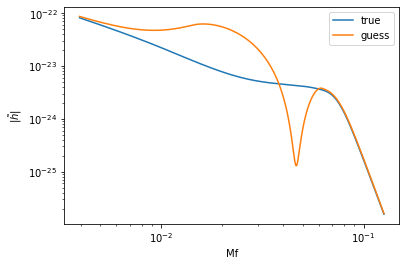

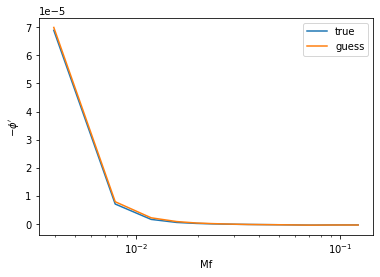

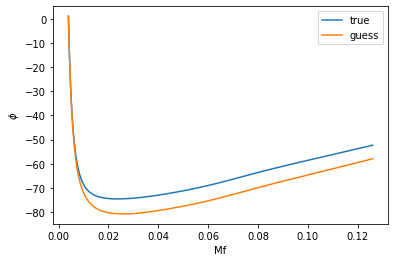

[-2.12748118 -1.84069516  1.08897833 -0.00462062  0.07560527  0.05131282
  0.02262412  0.0704293   0.10139075  0.07196166 -0.03805257 -0.10119357
  0.77504571 -0.28486075  0.3862015  -0.61955363  2.03405269 -0.00317629
 -0.0107295 ]


In [16]:
test_coeffs = _get_coeffs(theta_intrinsic[0], lambdas)
coeffs = get_coeffs(theta_intrinsic[0])
theta = theta_intrinsic[0]
M = theta[0] + theta[1]

true_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[0], theta_extrinsic, coeffs))
guess_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[0], theta_extrinsic, test_coeffs))
plt.loglog(fs * (M * gt), true_amp, label='true')
plt.loglog(fs * (M * gt), guess_amp, label='guess')
plt.xlabel('Mf')
plt.ylabel(r'$|\tilde{h}|$')
plt.legend()
plt.show()

true_angle = -jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[0], theta_extrinsic, coeffs)))
guess_angle = -jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[0], theta_extrinsic, test_coeffs)))
true_angle_diff = -(true_angle[2:] - true_angle[:-2]) / (2 * f_sep)
guess_angle_diff = -(guess_angle[2:] - guess_angle[:-2]) / (2 * f_sep)

plt.semilogx(fs[1::f_sep] * (M * gt), true_angle_diff[0::f_sep], label='true')
plt.semilogx(fs[1::f_sep] * (M * gt), guess_angle_diff[0::f_sep], label='guess')
plt.xlabel('Mf')
plt.ylabel(r'$-\phi^{\prime}$')
plt.legend()
plt.show()

plt.plot(fs * (M * gt), true_angle, label='true')
plt.plot(fs * (M * gt), guess_angle, label='guess')
plt.legend()
plt.xlabel('Mf')
plt.ylabel(r'$\phi$')
plt.show()

print((test_coeffs - coeffs) / coeffs)

In [ ]:
start_time = time.time()
print(start_time)

solver = jaxopt.LBFGS(fun=total_loss_amp, maxiter=10, max_stepsize=0.1, tol=1e-10, jit=False)
res_amp = solver.run(test_amp, test_phase, theta_intrinsic, theta_extrinsic, f_list)

print("--- %s seconds ---" % (time.time() - start_time))

1657287899.761371
--- 72.93044805526733 seconds ---


In [51]:
result_amp = jnp.resize(jnp.append(res_amp.params, test_phase), (19, 11))
print((result_amp - PhenomD_coeff_table) / PhenomD_coeff_table)
#print(jnp.max((test_amp - PhenomD_coeff_table[:7]) / PhenomD_coeff_table[:7]))
print('-------------------------------------------------------------------------------------------------------')
print(res_amp.state)

[[ 2.45378218e-03  8.01623566e-04 -1.74072418e-03  4.31710583e-03
   1.48089327e-03  9.22257036e-03 -4.99066014e-03 -1.22686322e-03
   8.86971223e-03  6.98742438e-04 -9.90462445e-03]
 [ 3.56583415e-03 -3.02473748e-03 -4.65648327e-03 -6.31289906e-03
   7.42337851e-03  6.89553573e-04 -9.06841048e-03  6.52959056e-03
   6.27148198e-03  9.75746273e-03  5.64739786e-03]
 [-2.70108951e-03 -5.86224570e-03  8.76863127e-03 -2.30707397e-03
   7.21398657e-04 -9.23655836e-03  7.82385177e-03 -8.01179846e-04
   3.90213470e-03 -3.07002117e-03 -5.26211310e-03]
 [-1.03997233e-01 -8.89465251e-03  9.96463239e-02 -6.02227097e-03
  -5.98593779e-03 -2.63035441e-01  1.58778173e-02 -1.70657496e-04
   1.83391631e+00 -7.68406964e-02  1.03436519e-03]
 [-3.45330206e+02 -2.11877673e+01  6.08100964e+02 -9.02007884e+00
   1.04675773e+00 -1.93005370e+03  1.78043330e+01 -1.81340102e+00
   1.56892568e+04 -1.24067648e+02  1.19540983e+01]
 [ 1.15865328e-02 -1.41013047e+00 -6.53125712e-02 -4.87940988e-03
   2.38773780e-03  

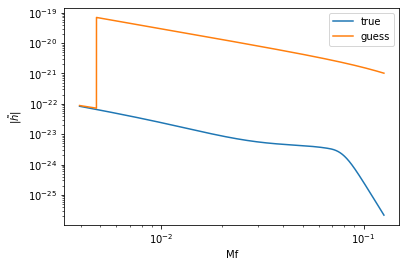

[8.79688922e-23 8.79089280e-23 8.78490549e-23 ... 1.02227381e-21
 1.02223371e-21 1.02219362e-21]


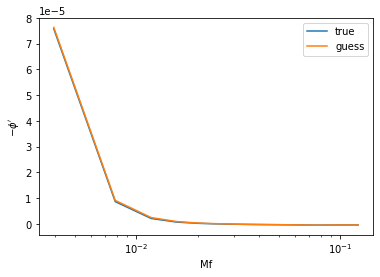

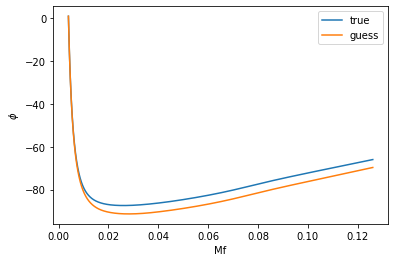

[-1.09841373 -1.28900224  0.92973381 -0.0022085   0.0474489   0.02627939
  0.0178819   0.04972723  0.19272487  0.10168195 -0.10914075 -0.06543117
  0.50609517 -0.13236294  0.22072591 -0.30493088  1.50788203 -0.00253946
 -0.00759172]


In [52]:
i = 1
test_coeffs = _get_coeffs(theta_intrinsic[i], lambdas)
coeffs = IMRPhenomD_utils.get_coeffs(theta_intrinsic[i])
theta = theta_intrinsic[i]
M = theta[0] + theta[1]

true_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[i], theta_extrinsic, coeffs))
guess_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[i], theta_extrinsic, _get_coeffs(theta_intrinsic[0], result_amp)))
plt.loglog(fs * (M * gt), true_amp, label='true')
plt.plot(fs * (M * gt), guess_amp, label='guess')
plt.xlabel('Mf')
plt.ylabel(r'$|\tilde{h}|$')
plt.legend()
plt.show()

print(guess_amp)

true_angle = -jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[i], theta_extrinsic, coeffs)))
guess_angle = -jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, theta_intrinsic[i], theta_extrinsic, test_coeffs)))
true_angle_diff = -(true_angle[2:] - true_angle[:-2]) / (2 * f_sep)
guess_angle_diff = -(guess_angle[2:] - guess_angle[:-2]) / (2 * f_sep)

plt.semilogx(fs[1::f_sep] * (M * gt), true_angle_diff[0::f_sep], label='true')
plt.semilogx(fs[1::f_sep] * (M * gt), guess_angle_diff[0::f_sep], label='guess')
plt.xlabel('Mf')
plt.ylabel(r'$-\phi^{\prime}$')
plt.legend()
plt.show()

plt.plot(fs * (M * gt), true_angle, label='true')
plt.plot(fs * (M * gt), guess_angle, label='guess')
plt.legend()
plt.xlabel('Mf')
plt.ylabel(r'$\phi$')
plt.show()

print((test_coeffs - coeffs) / coeffs)